In [7]:
!pip install yfinance
!pip install pandas

In [17]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import yfinance as yf
import os
from typing import Dict


class Backtester:

    def __init__(self, asset_names, asset_closes, signals, weights, risk_free_rate, market_returns,data_folder='Data'):
        self.data_folder = data_folder
        self.asset_names = asset_names
        self.asset_closes = asset_closes
        self.signals = signals
        self.weights = weights
        self.risk_free_rate = risk_free_rate
        self.market_returns = market_returns
        self.max_drawdown = 0.0
        self.max_seen_peak = 0
        self.load_data()

    def load_data(self):
        self.data = {}
        for asset_name in self.asset_names:
            file_path = os.path.join(self.data_folder, f'{asset_name}.csv')
            if os.path.exists(file_path):
                self.data[asset_name] = pd.read_csv(file_path, index_col=0, parse_dates=True)
            else:
                print(f'Data file for {asset_name} not found.')

    def calculate_asset_daily_returns(self):
        asset_daily_returns = pd.DataFrame()
        for asset_name, asset_data in self.asset_closes.items():
            if asset_name in self.signals:
            # Calculate daily returns for the asset and multiply by signals
               asset_daily_returns[asset_name] = self.data[asset_name]['Close'].pct_change()*self.signals[asset_name]
            else:
               print(f'No signals found for {asset_name}.')
        return asset_daily_returns
    
    def calculate_asset_annualized_returns(self):
        asset_daily_returns = self.calculate_asset_daily_returns()
        asset_annualized_returns = {}
        for asset_name, asset_daily_return in asset_daily_returns.items():
            total_days = len(asset_daily_return)
            if total_days > 0:
                asset_annualized_return = ((asset_daily_return + 1).prod()) ** (252 / total_days) - 1 
                asset_annualized_returns[asset_name] = asset_annualized_return
            else:
                print(f'No daily returns found for {asset_name}.')
        return asset_annualized_returns

    def calculate_asset_volatility(self, asset_daily_returns):
        asset_volatility = asset_daily_returns.std() * math.sqrt(252)
        return asset_volatility

    def plot_asset_daily_returns(self, asset_daily_returns):
        asset_daily_returns.plot(figsize=(10, 6))
        plt.title('Asset Daily Returns')
        plt.xlabel('Date')
        plt.ylabel('Daily Returns')
        plt.legend()
        plt.show()

    def plot_asset_volatility(self, asset_volatility):
        plt.bar(asset_volatility.index, asset_volatility.values)
        plt.title('Asset Volatility')
        plt.xlabel('Asset')
        plt.ylabel('Volatility')
        plt.xticks(rotation=45)
        plt.show()

    def calculate_portfolio_daily_returns(self, asset_daily_returns):
        pf_daily_returns = (asset_daily_returns * self.weights).sum(axis=1)
        return pf_daily_returns
    
    def calculate_portfolio_annualized_returns(self, asset_daily_returns):
        pf_daily_returns = self.calculate_portfolio_daily_returns(asset_daily_returns)
        total_days = len(pf_daily_returns)
        if total_days > 0:
            pf_annualized_return = ((pf_daily_returns + 1).prod()) ** (252 / total_days) - 1 
            return pf_annualized_return
        else:
            print(f'No daily returns found for pportfolio.')
            return None

    def calculate_portfolio_volatility(self, pf_daily_returns):
        pf_volatility = pf_daily_returns.std() * math.sqrt(252)
        return pf_volatility

    def calculate_annualized_sharpe_ratio(self, pf_daily_returns):
        avg_return = pf_daily_returns.mean()
        std_dev = pf_daily_returns.std()
        annualized_sharpe_ratio = (avg_return - self.risk_free_rate) / std_dev * math.sqrt(252)
        return annualized_sharpe_ratio

    def calculate_beta(self, pf_daily_returns):
        pf_daily_returns_aligned, market_returns_aligned = pf_daily_returns.align(self.market_returns, join='inner')
        cov_matrix = np.cov(pf_daily_returns_aligned, market_returns_aligned)
        portfolio_covariance = cov_matrix[0, 1]
        market_variance = np.var(market_returns_aligned)
        beta = portfolio_covariance / market_variance
        return beta

    def calculate_beta_up_down(self, daily_returns):
        daily_returns_aligned, market_returns_aligned = daily_returns.align(self.market_returns, join='inner')
        market_up_returns = market_returns_aligned[market_returns_aligned > 0]
        market_down_returns = market_returns_aligned[market_returns_aligned < 0]
        pf_up_returns = daily_returns_aligned[self.market_returns > 0]
        pf_down_returns = daily_returns_aligned[self.market_returns < 0]
        beta_up = self.calculate_beta(pf_up_returns)
        beta_down = self.calculate_beta(pf_down_returns)
        return beta_up, beta_down

    def start(self):
        self.max_drawdown = 0.0
        self.max_drawdown_duration = 0
        self.max_seen_peak = 0
        self.current_drawdown_duration = 0

    def calculate_max_drawdown(self, asset_name):
        price_series = self.asset_closes[asset_name]
        peak = price_series.iloc[0]
        max_drawdown = 0
        for price in price_series:
            if price > peak:
               peak = price
            drawdown = (peak - price) / peak
            if drawdown > max_drawdown:
               max_drawdown = drawdown
        self.max_drawdown = max_drawdown * 100

    def summary(self):
        asset_daily_returns = self.calculate_asset_daily_returns()
        asset_annualized_returns = self.calculate_asset_annualized_returns()
        asset_volatility = self.calculate_asset_volatility(asset_daily_returns)
        pf_daily_returns = self.calculate_portfolio_daily_returns(asset_daily_returns)
        pf_annualized_returns = self.calculate_asset_annualized_returns()
        pf_volatility = self.calculate_portfolio_volatility(pf_daily_returns)
        annualized_sharpe_ratio = self.calculate_annualized_sharpe_ratio(pf_daily_returns)
        beta = self.calculate_beta(pf_daily_returns)
        beta_up, beta_down = self.calculate_beta_up_down(pf_daily_returns)
        max_drawdown = self.max_drawdown

        signals_summary = {asset_name: self.signals[asset_name] for asset_name in self.asset_names}

        summary = {
            "asset_daily_returns": asset_daily_returns,
            "asset_annualized_returns": asset_annualized_returns,
            "asset_volatility": asset_volatility,
            "pf_daily_returns": pf_daily_returns,
            "pf_annualized_returns": pf_annualized_returns,
            "pf_volatility": pf_volatility,
            "annualized_sharpe_ratio": annualized_sharpe_ratio,
            "beta": beta,
            "beta_up": beta_up,
            "beta_down": beta_down,
            "max_drawdown": max_drawdown,
            "signals": signals_summary  # Include signals in summary
        }
        return summary

    def plot(self):
        # Plot portfolio returns
        plt.figure(figsize=(10, 5))
        plt.subplot(2, 1, 1)
        asset_returns = self.calculate_asset_daily_returns()
        pf_daily_returns = self.calculate_portfolio_daily_returns(asset_returns)
        plt.plot(asset_returns.index, asset_returns, label=asset_names, alpha=0.7)
        plt.plot(pf_daily_returns.index, pf_daily_returns, label='Portfolio Returns', color='red')
        plt.title('Asset and Portfolio Returns')
        plt.legend()

        # Plot portfolio volatility
        plt.subplot(2, 1, 2)
        plt.plot(pf_daily_returns.index, pf_daily_returns.rolling(window=20).std() * math.sqrt(252),
                 label='Portfolio Volatility', color='green')
        plt.title('Portfolio Volatility (Rolling 20-Day Window)')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def strategy_a(self, dfs: Dict[str, pd.DataFrame]):
        # Strategy A: Simple Moving Average Crossover
        # Buy when the short-term moving average crosses above the long-term moving average,
        # Sell when the short-term moving average crosses below the long-term moving average
        
        # Define short-term and long-term moving average windows
        short_window = 50
        long_window = 200
        # Initialize signals DataFrame
        signals = pd.DataFrame(index=dfs[self.asset_names[0]].index)
        signals['Signal'] = 0.0
        for asset_name, df in dfs.items():
            # Calculate short-term and long-term moving averages
            df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
            df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
            # Generate signals
            df['Signal'] = 0.0
            df.loc[df.index[short_window:], 'Signal'] = np.where(df['Short_MA'][short_window:] > df['Long_MA'][short_window:], 1.0, 0.0)
        return signals

    def run_strategy(self, strategy_name: str, data: Dict[str, pd.DataFrame]):
        if strategy_name == 'strategy_a':
            self.strategy_a(data)
        elif strategy_name == 'strategy_b':
            self.strategy_b(data)
        else:
            print("Invalid strategy name. Please provide either 'strategy_a' or 'strategy_b'.") 

max_drawdown (AAPL): 209.30112377586192
max_drawdown (AMZN): 251.3347443476019
max_drawdown (GOOGL): 243.0666528156439
Summary:
{'asset_daily_returns':                 AAPL      AMZN     GOOGL
2022-01-01       NaN       NaN       NaN
2022-01-02       NaN       NaN       NaN
2022-01-03       NaN       NaN       NaN
2022-01-04 -0.012692  0.016916 -0.004083
2022-01-05  0.026600 -0.018893  0.045876
...              ...       ...       ...
2023-12-27  0.000518 -0.000456  0.008126
2023-12-28  0.002226 -0.000261 -0.000997
2023-12-29 -0.005424  0.009388 -0.003851
2023-12-30       NaN       NaN       NaN
2023-12-31       NaN       NaN       NaN

[730 rows x 3 columns], 'asset_annualized_returns': {'AAPL': 0.0655641733192951, 'AMZN': -0.04703712777659286, 'GOOGL': 0.01787308849363134}, 'asset_volatility': AAPL     0.290637
AMZN     0.425748
GOOGL    0.348775
dtype: float64, 'pf_daily_returns': 2022-01-01    0.000000
2022-01-02    0.000000
2022-01-03    0.000000
2022-01-04    0.001734
2022-01-05 

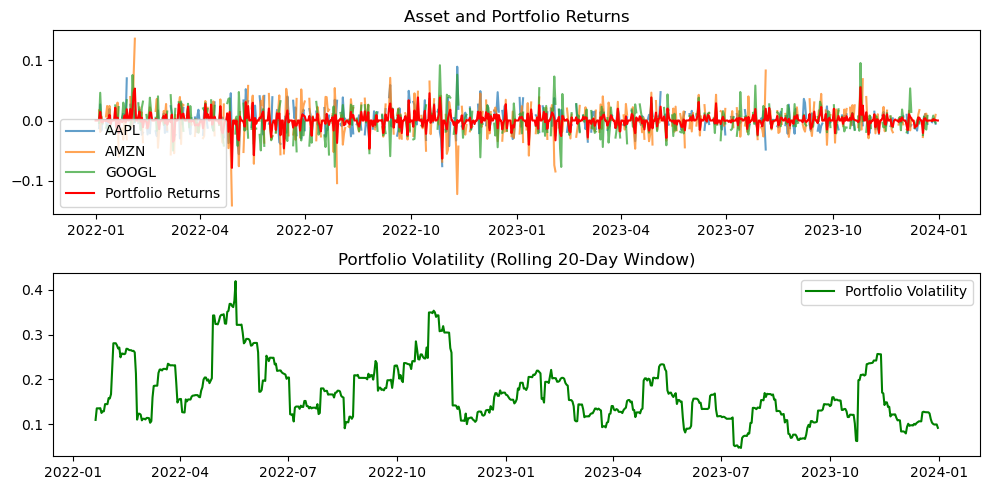

In [26]:
# Exampl usage
stock_symbols = ['AAPL', 'AMZN', 'GOOGL']
asset_names=stock_symbols
data_folder = 'Data'
for symbol in stock_symbols:
    file_path = os.path.join(data_folder, f'{symbol}.csv')
    if not os.path.exists(file_path):
        print(f'Downloading {symbol} data...')
        data = yf.download(symbol, start='2022-01-01', end='2023-12-31')
        data.to_csv(file_path)
        print(f'Data saved to {file_path}')

# Create data
dates = pd.date_range(start='2022-01-01', end='2023-12-31')
num_assets = len(stock_symbols)
num_days = len(dates)

# Load your data into a dictionary
data = {}
for symbol in stock_symbols:
    file_path = os.path.join(data_folder, f'{symbol}.csv')
    if os.path.exists(file_path):
        data[symbol] = pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        print(f'Data file for {symbol} not found.')

# Assume daily closing prices data for three assets
asset_closes = pd.DataFrame(np.random.randn(num_days, num_assets), index=dates, columns=stock_symbols)

# Assume trading signals data for three assets (e.g., 1 for buy, -1 for sell)
signals = pd.DataFrame(np.random.choice([-1, 1], size=(num_days, num_assets)), index=dates, columns=stock_symbols)

# Assume weights data for three assets
weights = np.array([0.3, 0.4, 0.3])  # Sum of weights for three assets should be 1

# Assume risk-free rate as 0.02
risk_free_rate = 0.02

# Assume market returns data
market_returns = pd.Series(np.random.randn(num_days), index=dates)

# Create a Backtester instance
backtester = Backtester(asset_names, asset_closes,signals,weights, risk_free_rate, market_returns, data_folder='Data')

# Calculate and print maximum drawdown
for asset_name, asset_close in asset_closes.items():
    backtester.calculate_max_drawdown(asset_name)  # Pass asset_name instead of asset_close
    print(f"max_drawdown ({asset_name}): {backtester.max_drawdown}")
    
# Run the strategy 
backtester.run_strategy('strategy_a', data)

# Calculate and print summary information
summary = backtester.summary()
print("Summary:")
print(summary)

# Plot asset and portfolio daily returns as well as portfolio volatility
backtester.plot()